In [0]:
%matplotlib inline

In [0]:
#Import MNIST dataset
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [0]:
#Extract from pickle serialized file
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


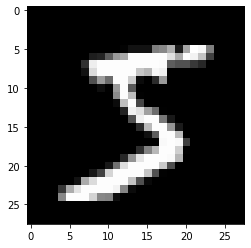

In [4]:
#Reshape each 28x28 image to 2 dimensions from 1 dimension (length 784)
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [10]:
#Import Torch and convert training and validation sets from numpy array to tensor
import torch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [0]:
import numpy as np
#Create fit function to calculate loss for each train/validation batch for each epoch
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

#Given a loss function perform backpropogation and zero gradients after each epoch
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [0]:
#Load Torch packages
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset

bs = 64  #set batch size
epochs = 3  # how many epochs to train for

#Load train and validation sets
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

#Use cross_entropy as activation function
loss_func = F.cross_entropy

In [0]:
#Create lambda function to pass custom functions such as printsize
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        #print(x.size())
        return self.func(x)

#Print shape of tensor after each layer to check progression of deepening the network
class PrintSize(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        print(x.size())

#Define preproces function to start with 28x28 pixel image at the beginning of each iteration
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [46]:
#Define CNN architecture using nn.Sequential with 4 Con2d layers followed by an average pooling layer and dense layer
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 96, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(96, 960, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Linear(2, 1),  # 28*28 from image dimension

    Lambda(lambda x: x.view(x.size(0), -1)),
)

#Set learning set and momentum to 0.9
opt = optim.SGD(model.parameters(), lr=0.6, momentum=0.9)

#Train CNN model
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 2.772585636138916
1 2.772585636138916
2 2.772585636138916
